# Effects of Framing Styles in Physical Activity Intervention
## Thalia Viranda, Katara Zhiduo Xie, Melissa Tan


This document contains our data cleaning and preprocessing steps. 


In [1]:
import os
import importlib
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Set working directory - CHANGE THIS TO YOUR PATH
main_dir = "/Users/thaliaviranda/Documents/GitHub/ORIE-5160-midterm-project/"
data_dir = os.path.join(main_dir, "data/")
figure_dir = os.path.join(main_dir, "figure/")

# Change the current working directory
os.chdir(main_dir)  

# Load packages
# Define a list of package names
packages = ["pandas", "numpy", "matplotlib", "seaborn", "statsmodels", "datetime"]

# Function to install and import packages
for pkg in packages:
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        globals()[pkg] = importlib.import_module(pkg)

/var/folders/d4/r8r1yf_553vdy3s6c02sl1z00000gn/T/ipykernel_54790/3820408650.py:5: DtypeWarning: Columns (21,22,38,39,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  suggestions_dat = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


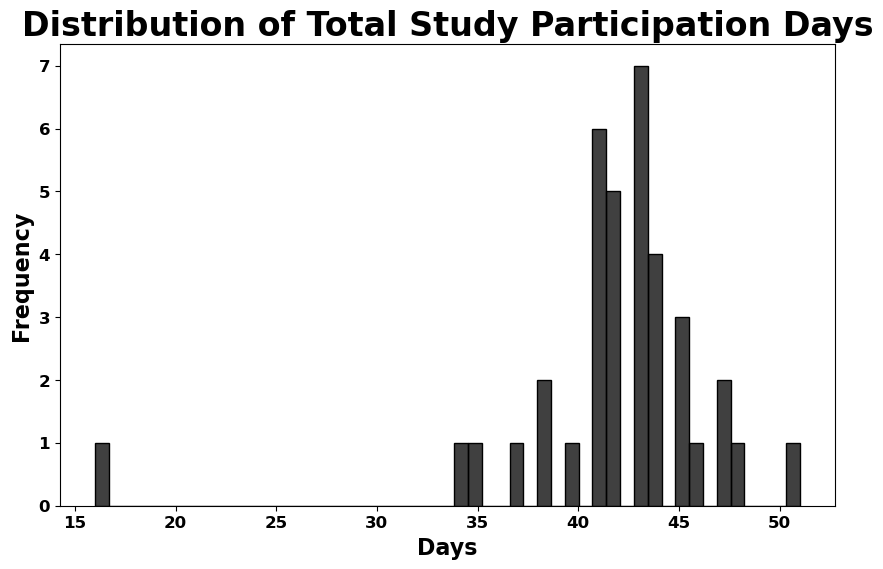

count    197524.000000
mean         27.155085
std          88.415296
min           1.000000
25%           1.000000
50%           4.000000
75%          27.000000
max        4929.000000
Name: steps, dtype: float64
Unique users in clean_steps_notif_users: 35
Unique users in mydata_steps_gf: 35


/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


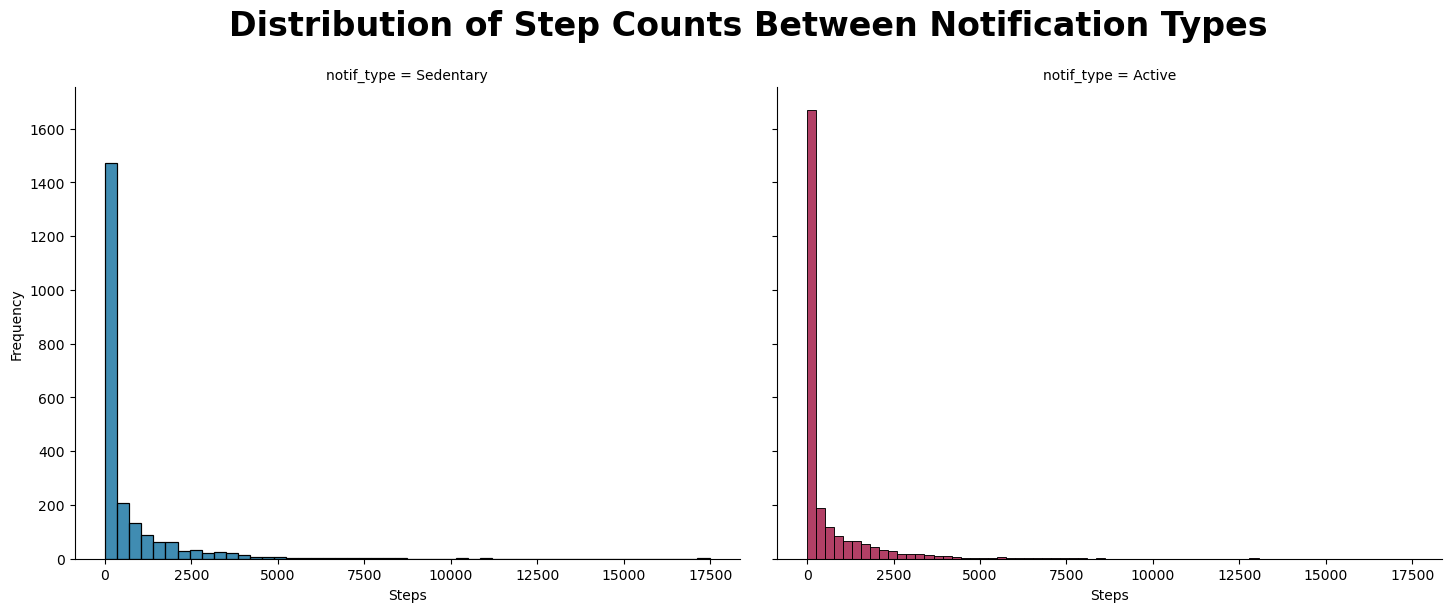

  notif_type               key      n  mean     var    sd   se  median   IQR
0     Active  selfeff_intake_r  49126  15.0    12.2   3.5  0.0    15.0   6.0
1     Active             steps  49126  27.1  7033.5  83.9  0.4     4.0  27.0
2  Sedentary  selfeff_intake_r  44898  14.7    14.1   3.8  0.0    15.0   5.0
3  Sedentary             steps  44898  29.1  9201.5  95.9  0.5     4.0  28.0


In [2]:
# Read CSV files
steps_gf = pd.read_csv(os.path.join(data_dir, "gfsteps.csv"))
steps_jb = pd.read_csv(os.path.join(data_dir, "jbsteps.csv"))
users_info = pd.read_csv(os.path.join(data_dir, "users.csv"))
suggestions_dat = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))


# Assuming `users_info` DataFrame is already loaded
# Select specific columns
mydata_qs = users_info.filter(regex="user.index|totaldays|^selfeff")


# Reverse Scoring and Summed Variables
mydata_qs = mydata_qs.assign(
    selfeff_badmood_intake_r = 6 - mydata_qs["selfeff.badmood.intake"],
    selfeff_notime_intake_r = 6 - mydata_qs["selfeff.notime.intake"],
    selfeff_tired_intake_r = 6 - mydata_qs["selfeff.tired.intake"],
    selfeff_vaca_intake_r = 6 - mydata_qs["selfeff.vaca.intake"],
    selfeff_precip_intake_r = 6 - mydata_qs["selfeff.precip.intake"],
    
    # Summing intake reverse-scored values
    selfeff_intake_r = lambda x: (
        x["selfeff_notime_intake_r"] + x["selfeff_tired_intake_r"] +
        x["selfeff_vaca_intake_r"] + x["selfeff_precip_intake_r"] +
        x["selfeff_badmood_intake_r"]
    ),

    selfeff_badmood_exit_r = 6 - mydata_qs["selfeff.badmood.exit"],
    selfeff_notime_exit_r = 6 - mydata_qs["selfeff.notime.exit"],
    selfeff_tired_exit_r = 6 - mydata_qs["selfeff.tired.exit"],
    selfeff_vaca_exit_r = 6 - mydata_qs["selfeff.vaca.exit"],
    selfeff_precip_exit_r = 6 - mydata_qs["selfeff.precip.exit"],

    # Summing exit reverse-scored values
    selfeff_exit_r = lambda x: (
        x["selfeff_notime_exit_r"] + x["selfeff_tired_exit_r"] +
        x["selfeff_vaca_exit_r"] + x["selfeff_precip_exit_r"] +
        x["selfeff_badmood_exit_r"]
    )
)


# Histogram of Total Days
plt.figure(figsize=(10, 6))
sns.histplot(mydata_qs['totaldays'], bins=51, color="black", edgecolor="black")
plt.title("Distribution of Total Study Participation Days", fontsize=24, fontweight="bold")
plt.xlabel("Days", fontsize=16, fontweight="bold")
plt.ylabel("Frequency", fontsize=16, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
# plt.gca().set_facecolor("transparent")
plt.savefig(os.path.join(figure_dir,"hist_totalday.png"), transparent=True)
plt.show()

# Creating Notification Type Data
notif_type = suggestions_dat[['user.index', 'decision.index', 'send', 'send.active', 'send.sedentary']]

# Merging Data
steps_notif = pd.merge(steps_gf, notif_type, on=['user.index', 'decision.index'], how='outer')
steps_notif_users = pd.merge(steps_notif, mydata_qs, on='user.index', how='outer')

# Converting columns to boolean
steps_notif_users['send'] = steps_notif_users['send'].astype(bool)
steps_notif_users['send.active'] = steps_notif_users['send.active'].astype(bool)

# Sorting and modifying user.index
steps_notif_users = steps_notif_users.sort_values(by='steps.utime')
steps_notif_users['user.index'] = pd.to_numeric(steps_notif_users['user.index'], errors='coerce')

# Summary Statistics
steps_summary = steps_notif_users['steps'].describe()
print(steps_summary)

# Exporting Data to CSV
steps_notif_users.to_csv(os.path.join(data_dir, "steps_notif_users_py.csv"), index=False)


# # Function to handle missing data in 'steps' column using LOCF
# def handle_missing_steps_locf(data):
#     data['steps'] = data['steps'].fillna(method='ffill')
#     return data

# # Apply LOCF to steps column
# steps_notif_users = handle_missing_steps_locf(steps_notif_users)

# Filter and transform steps_notif_users
clean_steps_notif_users = (
    steps_notif_users
    .loc[(steps_notif_users['send'] == True) & (~steps_notif_users['user.index'].isin([29, 22])) & (~steps_notif_users['decision.index'].isna())]  # Filtering for send == True and excluding users 29 and 22 and those with missing decision index
    .assign(
        notif_type=lambda x: x['send.active'].apply(lambda y: "Active" if y else "Sedentary"),
        steps_date=lambda x: pd.to_datetime(x['steps.utime']).dt.date
    )
    .dropna(subset=['notif_type'])  # Ensure notif_type is not NA
    .sort_values(by=['user.index', 'steps.utime'])
    .assign(
        day=lambda x: x.groupby('user.index')['steps_date'].transform(lambda y: pd.factorize(y)[0] + 1)
    )
)


# Summary statistics, filtering, and transformations for mydata_steps_gf
mydata_steps_gf = (
    clean_steps_notif_users
    .loc[:, ['user.index', 'steps_date', 'day', 'notif_type', 'decision.index', 'steps', 'selfeff_intake_r']]
    .groupby(['user.index', 'day', 'notif_type', 'decision.index', 'selfeff_intake_r'], as_index=False)
    .agg(
        n=('steps', 'size'),
        total_steps=('steps', 'sum')
    )
    .dropna(subset=['total_steps'])  # Filter rows where total_steps is NA
    .sort_values(by=['user.index', 'decision.index']
))

# View the count of unique users in clean_steps_notif_users and mydata_steps_gf
unique_user_count_clean = clean_steps_notif_users['user.index'].nunique()
unique_user_count_mydata = mydata_steps_gf['user.index'].nunique()

print(f"Unique users in clean_steps_notif_users: {unique_user_count_clean}")
print(f"Unique users in mydata_steps_gf: {unique_user_count_mydata}")

# Exporting Data to CSV
mydata_steps_gf.to_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"), index=False)

# STEP 1: Check for Normality (Histogram)
# Set up the FacetGrid with 'notif_type' as the facet variable
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
# Map sns.histplot to each facet, using the color for each 'notif_type'
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="total_steps", bins=50, color=color, edgecolor="black", ax=ax
    )
g.figure.suptitle("Distribution of Step Counts Between Notification Types", fontsize=24, weight='bold')
g.set_axis_labels("Steps", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"steps_dist_all_faceted.png"), transparent=True)
plt.show()

# STEP 2: Check for Overdispersion (Summary Statistics)
# Melt data to long format (similar to `gather`)
melted_data = pd.melt(
    clean_steps_notif_users, 
    id_vars=['notif_type'], 
    value_vars=['steps', 'selfeff_intake_r'],
    var_name='key', 
    value_name='value'
)

# Group by and calculate summary statistics
SUMM_mydata_steps_gf = (
    melted_data
    .groupby(['notif_type', 'key'])
    .agg(
        n=('value', 'size'),
        mean=('value', lambda x: round(np.mean(x.dropna()), 1)),
        var=('value', lambda x: round(np.var(x.dropna()), 1)),
        sd=('value', lambda x: round(np.std(x.dropna()), 1)),
        se=('value', lambda x: round(np.std(x.dropna()) / np.sqrt(x.notna().sum()), 1)),
        median=('value', lambda x: round(np.median(x.dropna()), 1)),
        IQR=('value', lambda x: round(np.percentile(x.dropna(), 75) - np.percentile(x.dropna(), 25), 1))
    )
).reset_index()

# Display summary statistics
print(SUMM_mydata_steps_gf)


# EDA (need to be moved to a different file later to follow the PCS framework)


## RQ 1a: Effects of Framing Styles on Step Counts

Let's do: 
- between notifications/decision index (what we did for presentation); so the models will be: 
    - GF: 
        - total steps ~ notif_type (i.e., notif_type predicting total steps)
        - 30 after ~ notif_type
        - 60 after ~ notif_type

    - JAWBONE: 
        - total steps ~ notif_type
        - 30 after ~ notif_type
        - 60 after ~ notif_type
    
- to do the analyses for the steps 30 and 60 min after the notification is sent for both GF AND and Jawbone data, we need to do the following data preprocessing
    - get total step counts 30 min and 60 min after the notification for GF and Jaw bone
    - replaced the total_steps in the model with these two variables  


P.S. KATARA, I feel like we should turn each of these into a function since we are repeating the same analyses for the different *dependent variables (total steps between notifs, 30min after notif, 60 min after notif)* and the different *datasets (GF, Jawbone)*. 

What do you think?



                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      total_steps 
No. Observations:      4681         Method:                  REML        
No. Groups:            35           Scale:                   1036165.7231
Min. group size:       94           Log-Likelihood:          -39113.4103 
Max. group size:       192          Converged:               Yes         
Mean group size:       133.7                                             
-------------------------------------------------------------------------
                          Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------
Intercept                  574.784   93.901  6.121 0.000  390.741 758.826
notif_type[T.Sedentary]    -49.040   30.270 -1.620 0.105 -108.369  10.288
Group Var               292013.119   71.773                              



/var/folders/d4/r8r1yf_553vdy3s6c02sl1z00000gn/T/ipykernel_54790/1247822297.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary = mydata_steps_gf.groupby('notif_type').agg(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


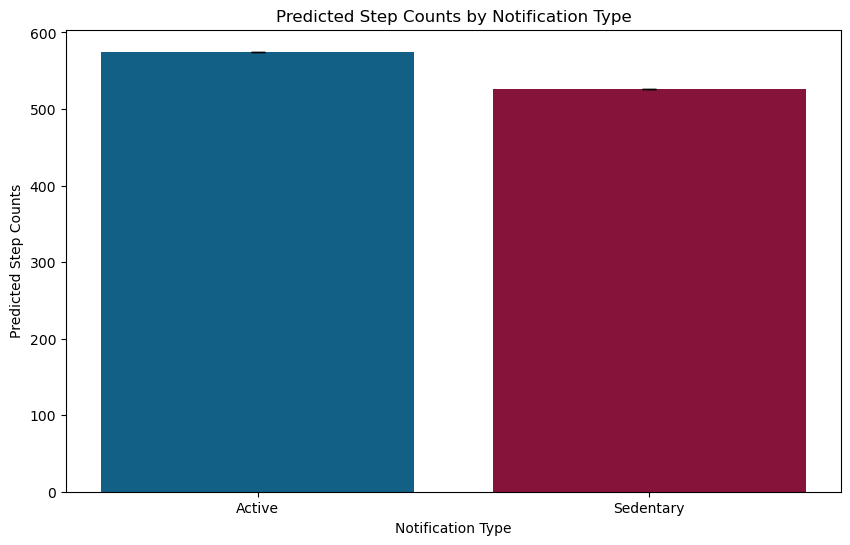

/var/folders/d4/r8r1yf_553vdy3s6c02sl1z00000gn/T/ipykernel_54790/1247822297.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary = mydata_steps_gf.groupby('notif_type').agg(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


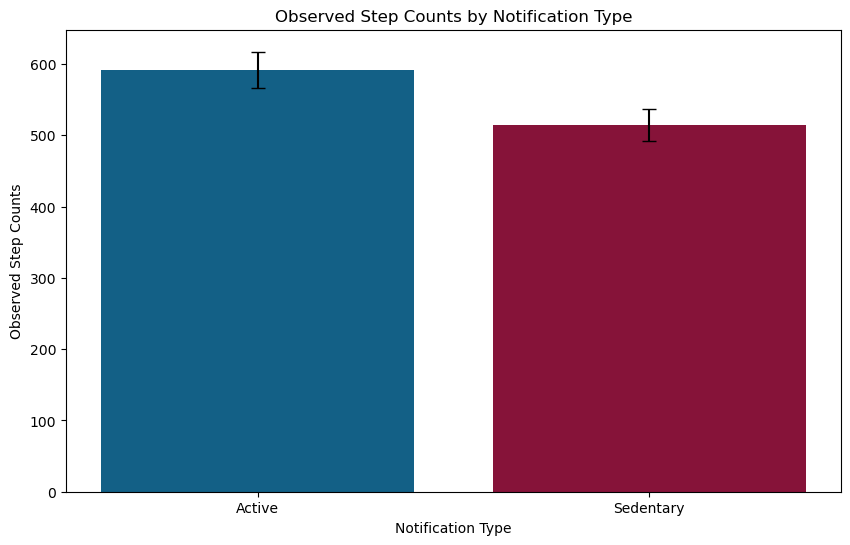

In [3]:
#====================================================================
# RQ 1: Effects of Framing Styles on Step Counts
# GF DATA: total between notif, 30min post notif, 60min post notif
#====================================================================

# load data
# mydata_steps_gf <- pd.read_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"))
mydata_steps_gf['user.index'] = mydata_steps_gf['user.index'].astype(str).astype('category')
mydata_steps_gf['notif_type'] = mydata_steps_gf['notif_type'].astype('category')

from statsmodels.formula.api import mixedlm

#====================================================================
# GF DATA: total between notif (total_steps)
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm = mixedlm("total_steps ~ notif_type", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm.fit()
print(result.summary())

# Add predicted values into dataframe and 
# Create a summary of predicted values for plotting
mydata_steps_gf['predicted_steps'] = result.predict()
predictions_summary = mydata_steps_gf.groupby('notif_type').agg(
    mean_pred=('predicted_steps', 'mean'),
    lower_ci=('predicted_steps', lambda x: np.quantile(x, 0.025)),
    upper_ci=('predicted_steps', lambda x: np.quantile(x, 0.975)),
    se_pred=('predicted_steps', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# plot PREDICTED values 
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(predictions_summary['notif_type'], predictions_summary['mean_pred'], 
             yerr=predictions_summary['se_pred'], fmt='none', color='black', capsize=5)
plt.title("Predicted Step Counts by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Step Counts")
plt.savefig(os.path.join(figure_dir, "pred_rq1.png"), transparent=True)
plt.show()

# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary = mydata_steps_gf.groupby('notif_type').agg(
    mean_obs=('total_steps', 'mean'),
    lower_ci=('total_steps', lambda x: np.quantile(x, 0.025)),
    upper_ci=('total_steps', lambda x: np.quantile(x, 0.975)),
    se_obs=('total_steps', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# plot OBSERVED values 
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary['notif_type'], observed_summary['mean_obs'], 
             yerr=observed_summary['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts")
plt.savefig(os.path.join(figure_dir,"obs_rq1.png"), transparent=True)
plt.show()


#====================================================================
# GF DATA: total steps 30 min after notif (total_steps_30)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification


#====================================================================
# GF DATA: total steps 60 min after notif (total_steps_60)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 60-min post the notification






# Start of analyses with the JAWBONE DATASET 


#====================================================================
# JAWBONE DATA: total between notif (total_steps)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification


#====================================================================
# JAWBONE DATA: total steps 30 min after notif (total_steps_30)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification


#====================================================================
# JAWBONE DATA: total steps 60 min after notif (total_steps_60)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 60-min post the notification

## RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts

For this, basically we want to add the interaction term between self_efficacy (as discrete variable: low, medium, and high) into the models above. 
- GF: 
    - total steps ~ notif_type * self_efficacy 
    - 30 after ~ notif_type * self_efficacy
    - 60 after ~ notif_type * self_efficacy

- JAWBONE: 
    - total steps ~ notif_type * self_efficacy 
    - 30 after ~ notif_type * self_efficacy
    - 60 after ~ notif_type * self_efficacy


/var/folders/d4/r8r1yf_553vdy3s6c02sl1z00000gn/T/ipykernel_54790/1102757616.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['notif_type', 'selfeff_category'])


0.25    13.0
0.50    16.0
0.75    18.0
Name: selfeff_intake_r, dtype: float64
  notif_type selfeff_category    n   mean      sd    se    IQR
0     Active              Low  720  504.2  1131.8  42.2  511.2
1     Active           Medium  837  567.5  1018.0  35.2  685.0
2     Active             High  654  718.2  1469.2  57.4  865.8
3  Sedentary              Low  820  453.8  1071.4  37.4  395.8
4  Sedentary           Medium  813  497.3   997.8  35.0  607.0
5  Sedentary             High  837  590.2  1176.9  40.7  602.0
                               Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               total_steps 
No. Observations:               4681                  Method:                           REML        
No. Groups:                     35                    Scale:                            1036378.9424
Min. group size:                94                    Log-Likelihood:                   -39089.4815 
Max. gro

/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarni

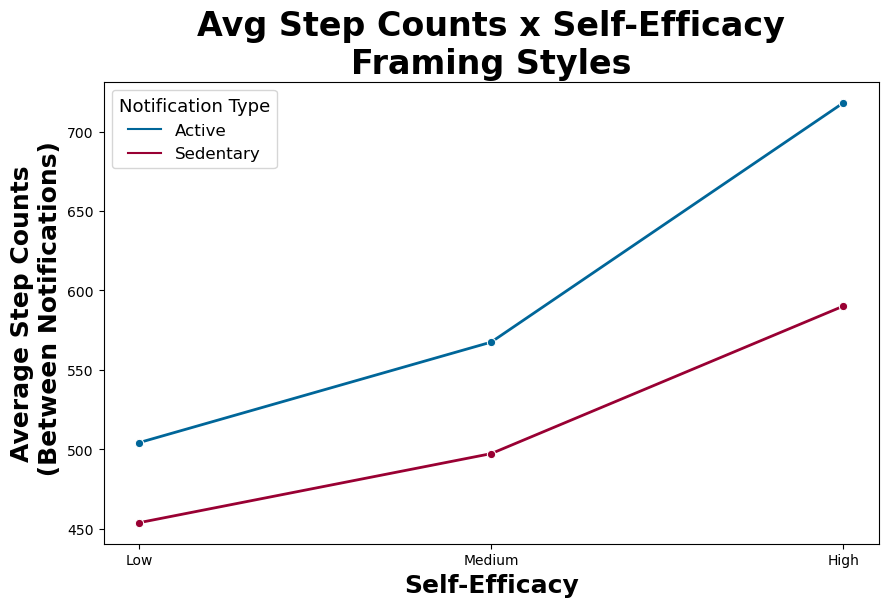

In [4]:
#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps between notif
#====================================================================

# load data
# mydata_steps_gf <- pd.read_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"))
mydata_steps_gf['user.index'] = mydata_steps_gf['user.index'].astype('category')
mydata_steps_gf['notif_type'] = mydata_steps_gf['notif_type'].astype('category')

# Define self efficacy as a discrete variable based on its quantile
# low (<=13), med (14-17 inclusive), high (>=18)
selfeff_intake_quantiles = mydata_steps_gf['selfeff_intake_r'].quantile([0.25, 0.5, 0.75])
print(selfeff_intake_quantiles)

# Categorize selfeff.intake_r for visualization
# low (<=13), med (14-17 inclusive), high (>=18)
mydata_steps_gf['selfeff_category'] = pd.cut(
    mydata_steps_gf['selfeff_intake_r'], bins=[-np.inf, 14, 18, np.inf], labels=["Low", "Medium", "High"], right=False
)

# Create summary table
SUMM_mydata_steps_gf = (
    mydata_steps_gf
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n=('total_steps', 'size'),
        mean=('total_steps', lambda x: round(np.mean(x), 1)),
        sd=('total_steps', lambda x: round(np.std(x), 1)),
        se=('total_steps', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR=('total_steps', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

print(SUMM_mydata_steps_gf)


from statsmodels.formula.api import mixedlm
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff = mixedlm("total_steps ~ notif_type * selfeff_category", mydata_steps_gf, groups=mydata_steps_gf["user.index"])
result = model_nb_glmm_notifxselfeff.fit()
print(result.summary())


# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_gf, x="selfeff_category", y="mean", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)
plt.title("Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Step Counts\n (Between Notifications)", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_bwnotif.png"), transparent=True)
plt.show()


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps 30 min after notif
#====================================================================


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps 60 min after notif
#====================================================================






# Start of analyses with the JAWBONE DATASET 



#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# Jawbone: total_steps between notif
#====================================================================


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# Jawbone: total_steps 30 min after notif
#====================================================================


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# JawboneF: total_steps 60 min after notif
#====================================================================



## RQ 2a: Effects of Framing Styles on User Engagement (min between notif and first meaningful steps (at least 60steps))


/var/folders/d4/r8r1yf_553vdy3s6c02sl1z00000gn/T/ipykernel_54790/2226631032.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

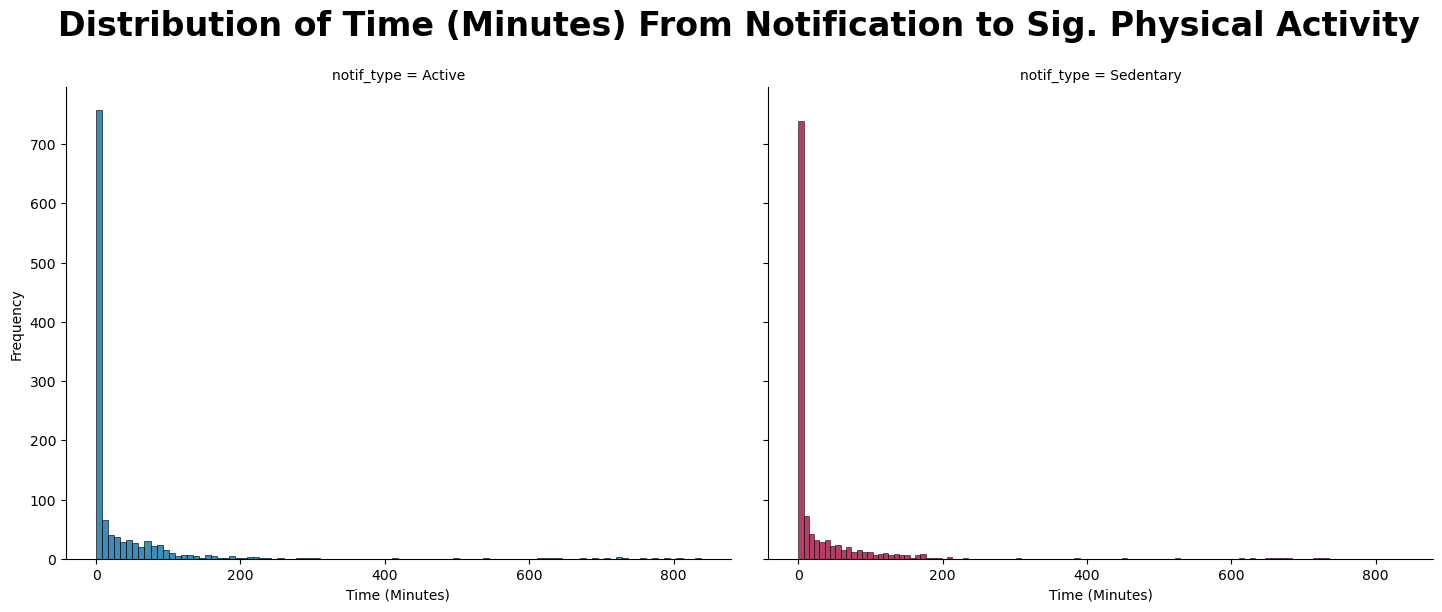

/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/d4/r8r1yf_553vdy3s6c02sl1z00000gn/T/ipykernel_54790/2226631032.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ux_predictions_summary = ux_eng.groupby('notif_type').agg(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
No artists with labels found to put in legend.  Note that artist

Linear mixed model fit by REML [’lmerMod’]
Formula: time_to_step_ge_60~notif_type+(1|user.index)

Family: gaussian	 Inference: parametric

Number of observations: 2355	 Groups: {'user.index': 25.0}

Log-likelihood: -13957.948 	 AIC: 27923.897

Random effects:

                   Name       Var     Std
user.index  (Intercept)   321.618  17.934
Residual                 8140.041  90.222

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: time_to_step_ge_60~notif_type+(1|user.index)

Family: gaussian	 Inference: parametric

Number of observations: 2355	 Groups: {'user.index': 25.0}

Log-likelihood: -13957.948 	 AIC: 27923.897

Random effects:

                   Name       Var     Std
user.index  (Intercept)   321.618  17.934
Residual                 8140.041  90.222

No random effect correlations specified

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)            34.984  26.2

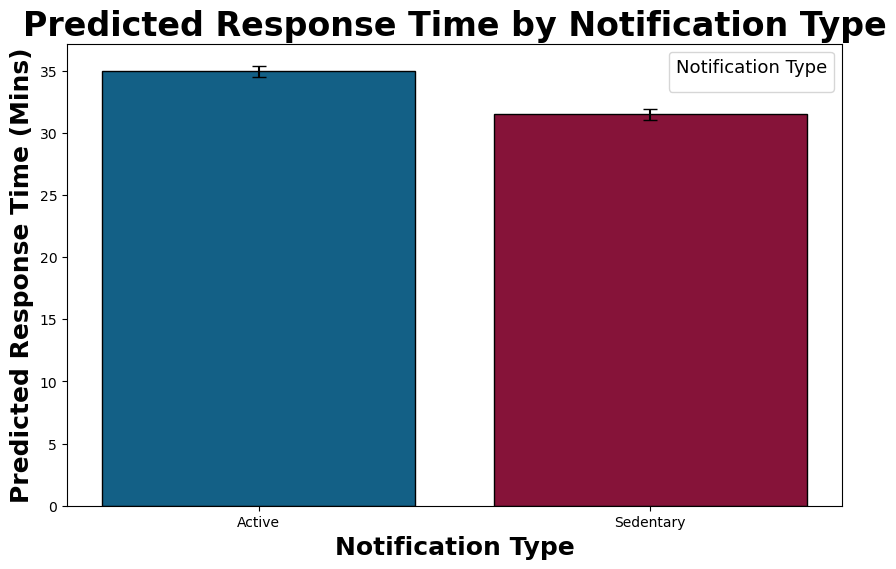

In [11]:
# Convert `steps.utime` to datetime format and sort within each group
clean_steps_notif_users['steps.utime'] = pd.to_datetime(clean_steps_notif_users['steps.utime'])

# Group data and calculate time to significant activity (>= 60 steps)
ux_eng = (
    clean_steps_notif_users
    .sort_values(['user.index', 'decision.index', 'steps.utime'])
    .dropna(subset=['steps'])  # Filter out rows where 'steps' is NA since we are finding only time with steps
    .groupby(['user.index', 'decision.index', 'notif_type'])
    .apply(lambda df: pd.Series({
        'first_step_time': df['steps.utime'].iloc[0],
        'step_ge_60_time': df.loc[df['steps'] >= 60, 'steps.utime'].iloc[0] if not df.loc[df['steps'] >= 60].empty else np.nan,
        'selfeff_intake_r': df['selfeff_intake_r'].iloc[0]
    }))
    .reset_index()
)

ux_eng['user.index'] = ux_eng['user.index'].astype(str).astype('category')
ux_eng['notif_type'] = ux_eng['notif_type'].astype('category')

# Calculate time to step >= 60 in minutes and handle missing or zero values
ux_eng['time_to_step_ge_60'] = (ux_eng['step_ge_60_time'] - ux_eng['first_step_time']).dt.total_seconds() / 60
ux_eng['time_to_step_ge_60'] = ux_eng['time_to_step_ge_60'].fillna(0.01).round(2) #use 0.01 because GLMM only deals with positive values
ux_eng = ux_eng.sort_values(['user.index', 'decision.index'])



# Plot Faceted Histogram of Resp Time
# Set up the FacetGrid with 'notif_type' as the facet variable
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(ux_eng, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
# Map sns.histplot to each facet, using the color for each 'notif_type'
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=ux_eng[ux_eng['notif_type'] == notif_type],
        x="time_to_step_ge_60", bins=100, color=color, edgecolor="black", ax=ax
    )
g.figure.suptitle("Distribution of Time (Minutes) From Notification to Sig. Physical Activity", fontsize=24, weight='bold')
g.set_axis_labels("Time (Minutes)", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"resptime_faceted.png"), transparent=True)
plt.show()



from pymer4.models import Lmer
# Fit the model using pymer4 (requires R to be installed and accessible)
model_response_time = Lmer("time_to_step_ge_60 ~ notif_type + (1 | user.index)", data=ux_eng)
model_response_time.fit()
print(model_response_time.summary())


# Generate predictions on the original scale
# THIS SHOULD BE REVISITED. DO WE WANT TO SPLIT OUR DATASET INTO TRAII
ux_eng['predicted_steps'] = model_response_time.predict(data=ux_eng, skip_data_checks=True, verify_predictions=False)


# Summarize predicted values by notification type
ux_predictions_summary = ux_eng.groupby('notif_type').agg(
    mean_pred=('predicted_steps', 'mean'),
    lower_ci=('predicted_steps', lambda x: np.quantile(x, 0.025)),
    upper_ci=('predicted_steps', lambda x: np.quantile(x, 0.975)),
    se_pred=('predicted_steps', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()


# Plot PREDICTED Response Time 
plt.figure(figsize=(10, 6))
sns.barplot(data=ux_predictions_summary, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"}, edgecolor="black")
plt.errorbar(ux_predictions_summary['notif_type'], ux_predictions_summary['mean_pred'], 
             yerr=ux_predictions_summary['se_pred'], fmt='none', color='black', capsize=5)
plt.title("Predicted Response Time by Notification Type", fontsize=24, fontweight='bold')
plt.xlabel("Notification Type", fontsize=18, fontweight='bold')
plt.ylabel("Predicted Response Time (Mins)", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save plot
plt.savefig(os.path.join(figure_dir, "pred_rq2.png"), transparent=True)
plt.show()